# Solar System Mass-Semimajor Axis

Plots mass versus orbital semimajor axis for the solar system.  Masses are in units of Earth mass, and
semimajor axes are in units of au.

Variations include using blackbody equilibrum temperature instead of semimajor axis, lines delineating
different condensates, and the water and N2 ice lines.

## Data Files

Plots are made using data in accompanying files
 * `MassOrbit_Major.csv` - mass and orbit data for major solar system bodies (planets, dwarfs, and giant moons)
 * `MPC_MainBeltPlus.csv` - astroids in the main belt, jupiter trojans, hildas, etc.

We retrieve TNOs and Centaurs from the MPC using `astroquery`.  We don't use this for the main belt asteroids
et al. as the current limits 16k objects per query.

Condensation temperatures for a species of interest are drawn from Lodders, 2003, ApJ, 591, 1220, Table 8,
Table 7, (Magnetite = Fe3O4 and Troilite = FeS), and Table 10 (Ices - water, methane, ammonia, graphite,
methane clathrate).

In [1]:
import os
import sys
import math
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, LogLocator, NullFormatter

# astroquery for the MPC database

from astroquery.mpc import MPC

# suppress nuisance warnings

import warnings
warnings.filterwarnings('ignore',category=UserWarning, append=True)

## Standard Plot Format

Setup the standard plotting format and make the plot.  

#### Aspect Ratio

`aspect` sets the aspect ratio, width/height.  The default aspect ratio is 4:3, 1:1 for square plots, 
and 5:2 (2.5:1) for spectra, and equal aspect ratio for images and plots of Cartesian coordinates.
Use a formula instead of decimal when the result is a fraction (example: `aspect = 4.0/3.0` instead of
`aspect=1.33`).

In [2]:
# aspect ratio

plotWide = True # wide-screen vs. letter sized

if plotWide:
    aspect = 16.0/9.0 # wide-screen
    aspStr = '16x9'
else:
    aspect = 4.0/3.0
    aspStr = '4x3'

#
# Don't change these unless you really need to (we never have)
#
# fPage is the horizontal fraction of the page occupied by the figure, default 1.0
#
# scaleFac is the LaTeX includegraphics scaling in units of \textwidth, default 1.0
#

fPage = 1.0
scaleFac = 0.85

# Text width in inches - don't change, this is defined by the print layout

textWidth = 6.0 # inches

# Graphic dimensions depending on bitmap or vector format (draft vs production)

figFmt = 'png'
dpi = 600
plotWidth = dpi*fPage*textWidth
plotHeight = plotWidth/aspect
axisFontSize = 10
labelFontSize = 8
lwidth = 0.5
axisPad = 5
wInches = fPage*textWidth # float(plotWidth)/float(dpi)
hInches = wInches/aspect  # float(plotHeight)/float(dpi)
    
# LaTeX is used throughout for markup of symbols, Times-Roman serif font

plt.rc('text', usetex=True)
plt.rc('font', **{'family':'serif','serif':['Times-Roman'],'weight':'bold','size':'16'})

# Font and line weight defaults for axes

matplotlib.rc('axes',linewidth=lwidth)
matplotlib.rcParams.update({'font.size':axisFontSize})

# axis and label padding

plt.rcParams['xtick.major.pad']=f'{axisPad}'
plt.rcParams['ytick.major.pad']=f'{axisPad}'
plt.rcParams['axes.labelpad'] = f'{axisPad}'

## Solar system data

### Planets, Dwarf Planets, and Giant Moons

Planets, dwarf planets, and giant moons are from the JPL Solar System Dynamics database, extracted and organized
into a single CSV file `MassOrbit_Major.csv`.  For this plot we use 4 columns:
 * `Body` - name of the body
 * `a` - orbit semimajor axis in au
 * `ME` - mass in units of M$_E$=5.97271$\times$10$^{24}$ kg
 * `Type` - body type code: T = terrestrial planet, G = gas giant, I = ice giant, D = dwarf planet, DC = dwarf planet candidate, GM = giant moon.

In [3]:
majorFile = 'MassOrbit_Major.csv'

data = pd.read_csv(majorFile,comment='#')
bodyName = np.array(data['Body'])
bodyType = np.array(data['Type'])
bodyMass = np.array(data['ME'])
bodyAU = np.array(data['a'])
bodyTeq = 278.0/np.sqrt(bodyAU)

# colors etc.

bodySize = {'T':5,'G':8,'I':6,'D':4,'DC':3,'GM':3}
bodyColor = {'T':'#bbbbbb','G':'beige','I':'cyan','D':'snow','DC':'white','GM':'orange'}

### Asteroids

Asteroids masses are estimates from the MPC database.  Masses are based on a median density
of 2000 kg/m$^3$ and effective diameter and geometric albedo of 0.15 - not great but it
is representative enough for our purposes.
 * `a` - semimajor axis in au
 * `H` - absolute magnitude
 
Equilibrium temperature is for a blackbody for a fast rotator in K
 
### TNOs

Trans-neptunian objects from the MPC database with masses estimated from H magnitudes and a median density
of 1000 kg/m$^3$.  Not great, but representative enough for our purposes.  Includes a few centaurs.
 

In [4]:
Mearth = 5.97217e24 # kg

# asteroids (main belt, trojans, hildas, and others in MPC)

astFile = 'MPC_MainBeltPlus.csv'
data = pd.read_csv(astFile,comment='#')

tmpAU = np.array(data['a'])
astH = np.array(data['H'])

Aast = 0.15 # typical geometric albedo of an asteroid

astRad = 10.0**(3.1236 - 0.5*np.log10(Aast) - 0.2*astH)*2000 # photometric radius in meters
astRho = 2000.0 # kg/m^3

tmpMass = 4*np.pi*astRad**3*astRho/(3*Mearth)
maxMass = 1.0e-4 # Mearth

astAU = tmpAU[np.where(tmpMass < maxMass)]
astMass = tmpMass[np.where(tmpMass < maxMass)]
astTeq = 278.0/np.sqrt(astAU)

# TNOs

R0 = 2950.0 # km - for H=0, Ab=0.05
tnoRho = 1000.0 # kg/m^3

# use astroquery to retrieve TNOs and Centaurs (orbit_type=10), with q>5.2au and a>20au
result = MPC.query_objects('asteroid',
                           semimajor_axis_min=7.0,
                           perihelion_distance_min=5.2,
                           absolute_magnitude_max=25.0,
                           orbit_type=10,
                           return_fields='semimajor_axis,absolute_magnitude,orbit_type')

# retrieve the orbit elements

tmpAU = np.array([float(d.get('semimajor_axis',None)) for d in result])
tnoH = np.array([float(d.get('absolute_magnitude',None)) for d in result])

#tnoFile = 'TNOs_MPC_2023Oct17.csv'
#data = pd.read_csv(tnoFile,comment='#')

#tmpAU = np.array(data['a'])
#tnoH = np.array(data['Hmag'])

tnoRad = R0*1000*10.0**(-0.2*tnoH) # meters
tmpMass = 4*np.pi*tnoRad**3*tnoRho/(3*Mearth)
tmpTeq = 278.0/np.sqrt(tmpAU)

maxMass = 1.0e-4 # Mearth
minAU = 7 # au
minTeq = 100.0

tnoAU = tmpAU[np.where((tmpMass < maxMass) & (tmpAU > minAU))]
tnoMass = tmpMass[np.where((tmpMass < maxMass) & (tmpAU > minAU))]
tnoTeq = 278.0/np.sqrt(tnoAU)

## Condensation Temperatures

Condensation temperatures for a few species of interest.  Data are from Lodders, 2003, ApJ, 591, 1220, Table 8,
Table 7, (Magnetite = Fe3O4 and Troilite = FeS), Table 10 (Ices - water, methane, ammonia, graphite, methane clathrate).



In [5]:
species = ['Fe3O4','Graphite','FeS','H2O','NH3','Clathrate','N2','CH4']
Tcond = {'Fe3O4':371,
         'Graphite':626, 
         'FeS':704,
         'H2O':182,
         'NH3':131,
         'Clathrate':78,
         'N2':58,
         'CH4':41}
Tlabels = {'Fe3O4':r'Fe$_3$O$_4$',
           'Graphite':'Graphite',
           'FeS':'FeS',
           'H2O':r'H$_2$O Ice',
           'NH3':r'NH$_3$ Ice',
           'Clathrate':r'CH$_4$-7H$_2$O',
           'N2':r'N$_2$ Ice',
           'CH4':r'CH$_4$ Ice'}

## Plot the figure

Plot M vs a for solar system bodies.  Annotate with colors and labels for specific bodies.

Also mark the tidal radius at ~10$^5$ au, and the approximage range of the main Oort cloud (10$^4$ to 10$^5$ au
and objects up to masses of ~3$\times$10$^{-6}$M$_E$.

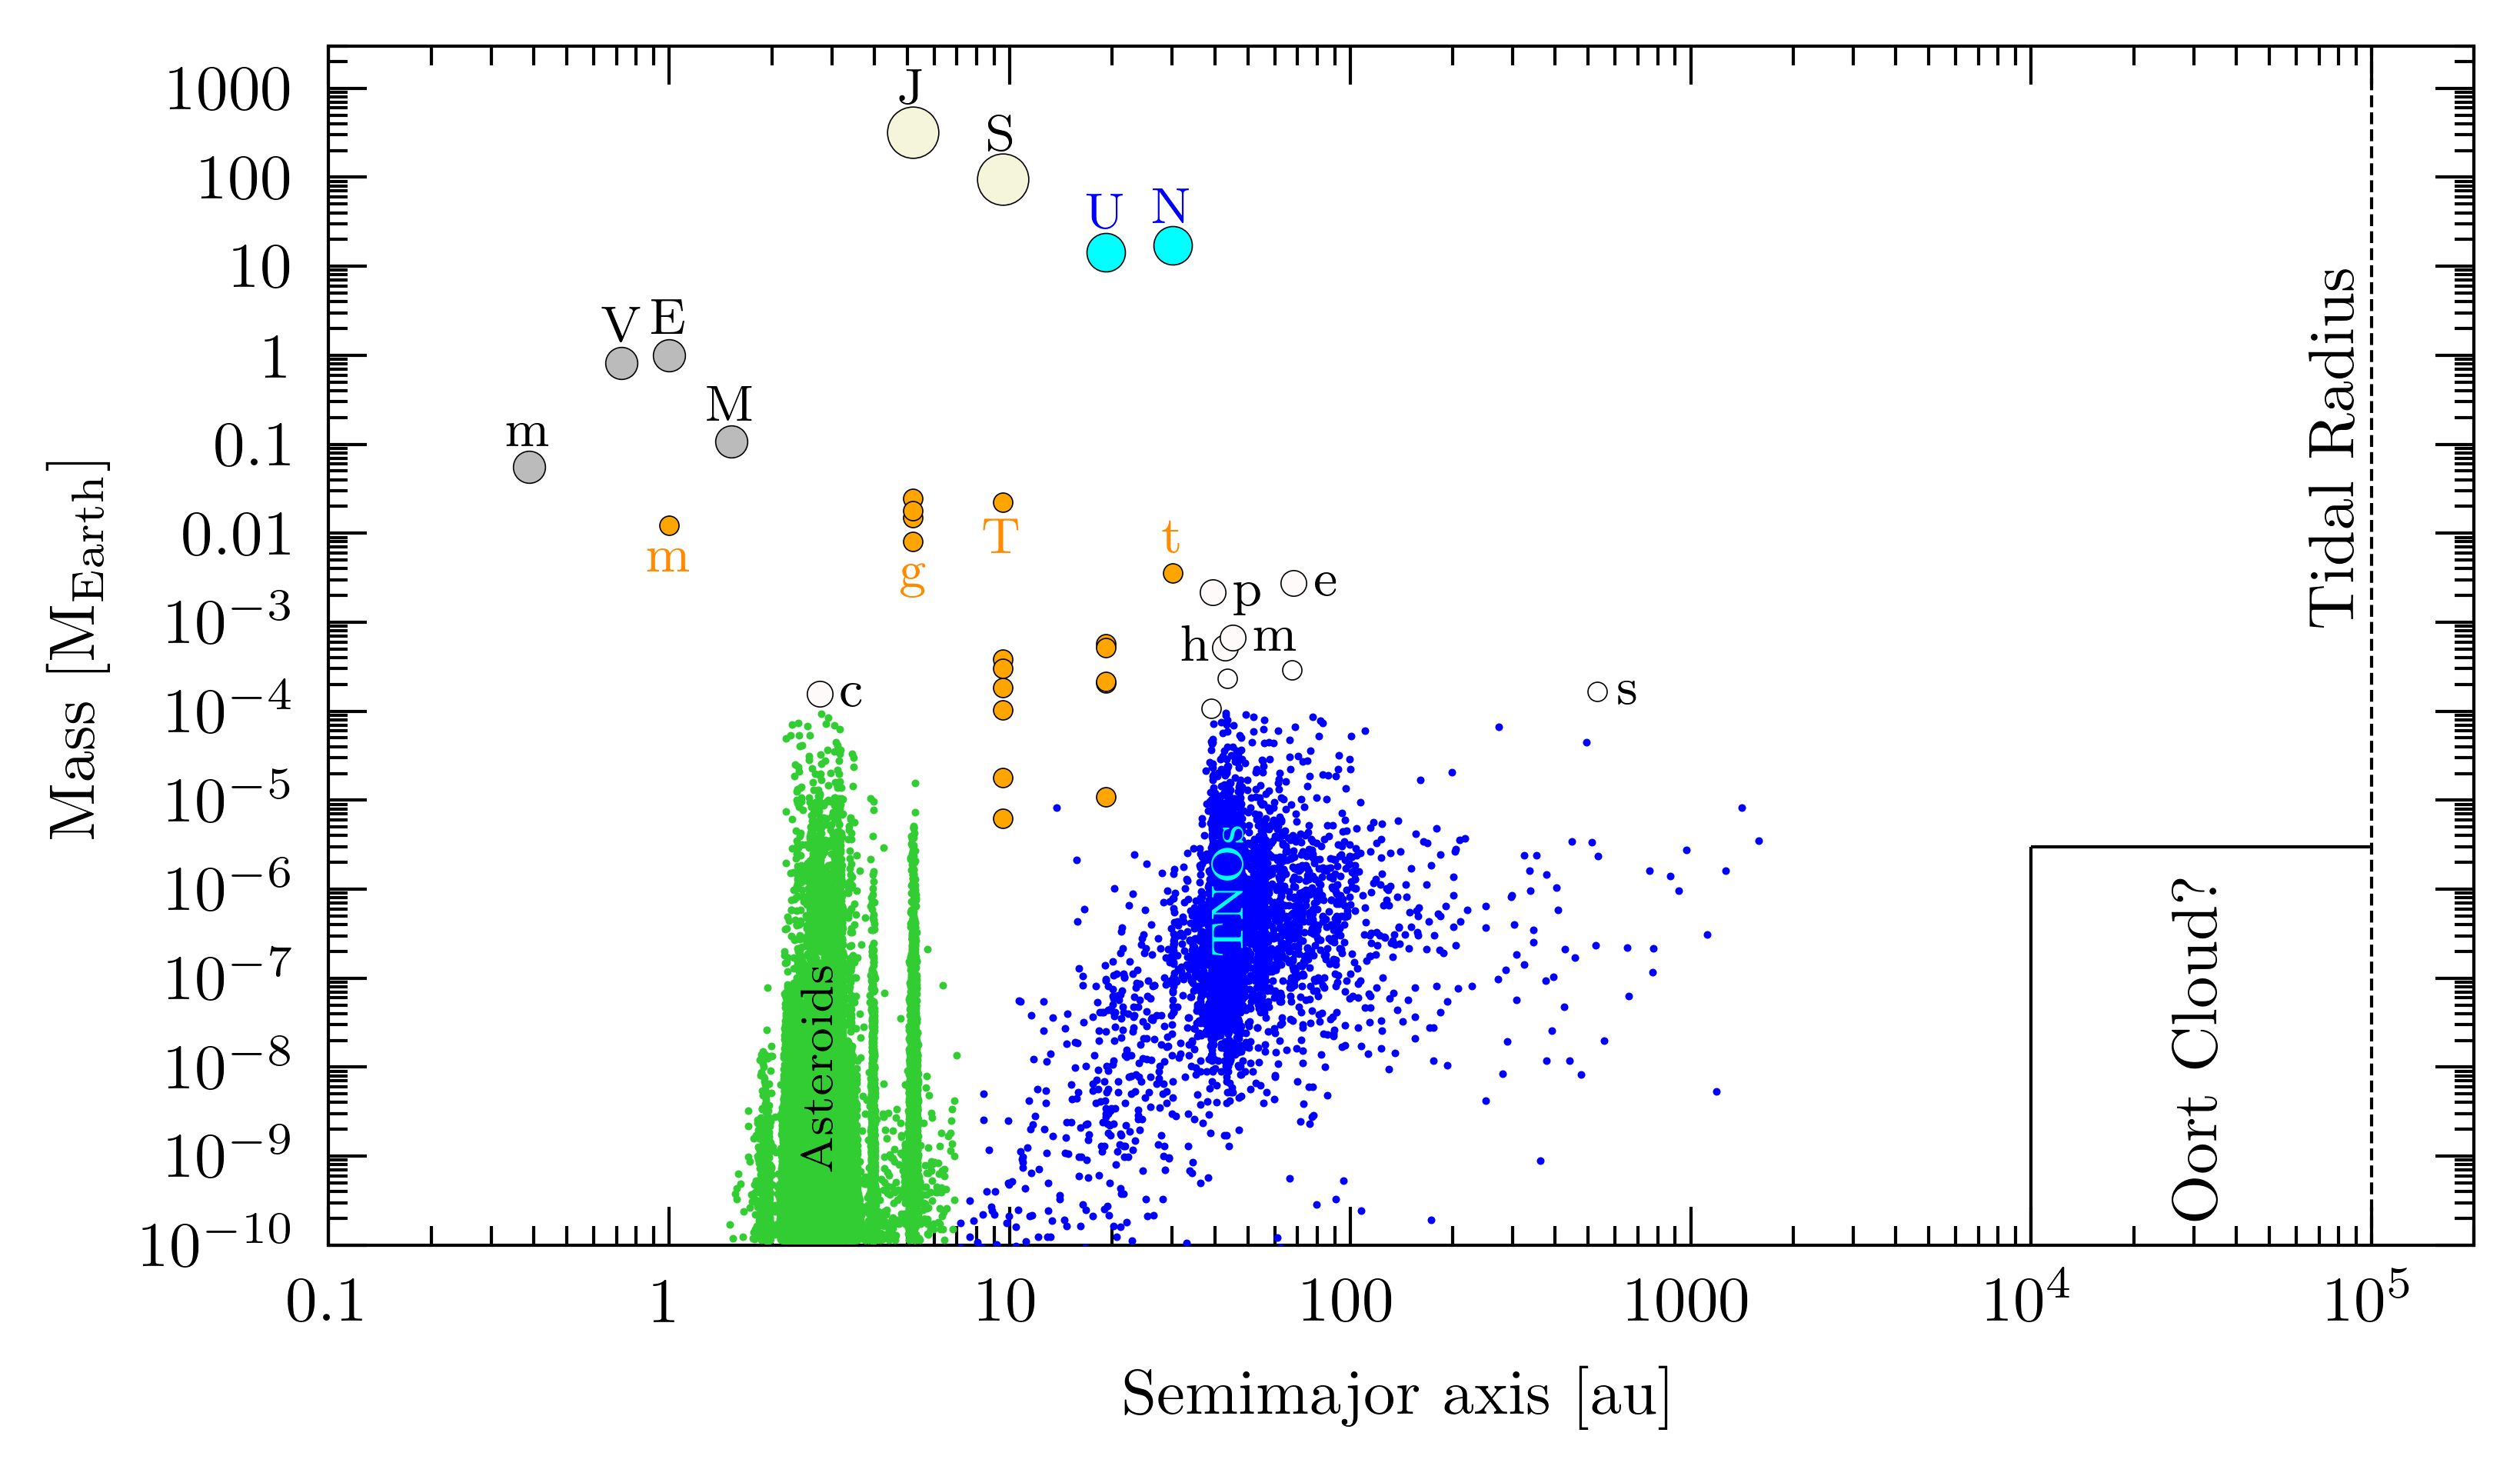

In [6]:
plotFile = f'solSys_MA_{aspStr}.png'

# axis limits

aMin = 0.1 # au
aMax = 2.0e5 # au
mMin = 1.0e-10 # M_earth
mMax = 3000. # M_earth

# do it

fig,ax = plt.subplots(figsize=(wInches,hInches),dpi=dpi)

ax.tick_params('both',length=6,width=lwidth,which='major',direction='in',top=True,right=True)
ax.tick_params('both',length=3,width=lwidth,which='minor',direction='in',top=True,right=True)

ax.set_xlim(aMin,aMax)
ax.set_xscale('log')
ax.set_xticks([0.1,1,10,100,1000,1e4,1e5])
ax.set_xticklabels(['0.1','1','10','100','1000','10$^{4}$','10$^{5}$'])
ax.set_xlabel(r'Semimajor axis [au]',fontsize=axisFontSize)

ax.set_ylim(mMin,mMax)
ax.set_yscale('log')
ax.yaxis.set_major_locator(LogLocator(base=10.0,subs=(1.0,),numticks=100))
ax.yaxis.set_minor_locator(LogLocator(base=10.0,subs=np.arange(2,10)*0.1,numticks=100))
ax.yaxis.set_minor_formatter(NullFormatter())
ax.set_yticks([1.0e-10,1.0e-9,1.0e-8,1.0e-7,1.0e-6,1.0e-5,0.0001,0.001,0.01,0.1,1,10,100,1000])
ax.set_yticklabels([r'10$^{-10}$',r'10$^{-9}$',r'10$^{-8}$',r'10$^{-7}$',r'10$^{-6}$',
                    r'10$^{-5}$',r'10$^{-4}$',r'10$^{-3}$','0.01','0.1','1','10','100','1000'])
ax.set_ylabel(r'Mass [M$_{\rm Earth}$]',fontsize=axisFontSize)

# Major bodies (planets, dwarf planets, giant moons)

for i in range(len(bodyName)):
    # print(bodyName[i])
    t = bodyType[i]
    ax.plot(bodyAU[i],bodyMass[i],'o',mfc=bodyColor[t],mec='black',ms=bodySize[t],mew=0.2,zorder=10)
    if t == 'D':
        labelTxt = bodyName[i].lower()
        if bodyName[i] in ['Pluto','Eris','Ceres']:
            ax.text(1.15*bodyAU[i],bodyMass[i],labelTxt[0],va='center',ha='left',fontsize=labelFontSize,
                    color='black')
        elif bodyName[i] == 'Makemake':
            ax.text(1.15*bodyAU[i],bodyMass[i],'m',va='center',ha='left',fontsize=labelFontSize,
                    color='black')
        elif bodyName[i] == 'Haumea':
            ax.text(bodyAU[i]/1.1,bodyMass[i],'h',va='center',ha='right',fontsize=labelFontSize,
                    color='black')
            
    elif t == 'GM':
        if bodyName[i]=='Europa':
            ax.text(bodyAU[i],bodyMass[i]/1.3,'g',va='top',ha='center',fontsize=labelFontSize,color='darkorange')
        elif bodyName[i]=='Titan':
            ax.text(bodyAU[i],bodyMass[i]/1.5,'T',va='top',ha='center',fontsize=labelFontSize,color='darkorange')
        elif bodyName[i]=='Moon':
            ax.text(bodyAU[i],bodyMass[i]/1.3,'m',va='top',ha='center',fontsize=labelFontSize,color='darkorange')
        elif bodyName[i]=='Triton':
            ax.text(bodyAU[i],1.3*bodyMass[i],'t',va='bottom',ha='center',fontsize=labelFontSize,color='darkorange')

    elif t == 'DC':
        if bodyName[i] == 'Sedna':
            ax.text(1.15*bodyAU[i],bodyMass[i],'s',va='center',ha='left',fontsize=labelFontSize,
                    color='black')

    elif t == 'G':
        labelTxt = bodyName[i]
        ax.text(bodyAU[i],1.6*bodyMass[i],labelTxt[0],va='bottom',ha='center',fontsize=labelFontSize,
                color='black')    
    elif t == 'I':
        labelTxt = bodyName[i]
        ax.text(bodyAU[i],1.4*bodyMass[i],labelTxt[0],va='bottom',ha='center',fontsize=labelFontSize,
                color='blue')    
    elif t == 'T':
        labelTxt = bodyName[i][0]
        if bodyName[i]=='Mercury':
            ax.text(bodyAU[i],1.35*bodyMass[i],'m',va='bottom',ha='center',fontsize=labelFontSize,
                color='black')
        else:
            ax.text(bodyAU[i],1.35*bodyMass[i],labelTxt,va='bottom',ha='center',fontsize=labelFontSize,
                color='black')
        
# minor planets

ax.plot(astAU,astMass,'o',mfc='limegreen',mec='limegreen',mew=0.2,ms=1,zorder=8)
ax.text(2.8,1.0e-8,'Asteroids',va='center',ha='center',rotation=90,fontsize=7,zorder=10)

ax.plot(tnoAU,tnoMass,'o',mfc='blue',mec='blue',mew=0.2,ms=1,zorder=8)
#ax.text(45,1.0e-10,'TNOs',color='blue',va='center',ha='center',rotation=90,fontsize=labelFontSize,zorder=10)
ax.text(45,1.0e-6,'TNOs',color='cyan',va='center',ha='center',rotation=90,fontsize=7,zorder=10)

# Tidal radius (approximate)

ax.vlines(1.0e5,mMin,mMax,ls=['--'],colors=['black'],lw=0.5)
ax.text(8e4,math.sqrt(3.0e-6*3000),'Tidal Radius',ha='center',va='center',rotation=90,
        fontsize=axisFontSize,color='black')

# Oort Cloud (very approximate)

ax.vlines(1.0e4,mMin,3.0e-6,ls=['-'],colors=['black'],lw=0.5)
ax.hlines(3.0e-6,1.0e4,1.0e5,ls=['-'],colors=['black'],lw=0.5)
ax.text(math.sqrt(1e4*1e5),math.sqrt(mMin*3.0e-6),'Oort Cloud?',ha='center',va='center',rotation=90,
        fontsize=axisFontSize,color='black')

# make the plot and hardcopy

plt.savefig(plotFile,bbox_inches='tight',facecolor='white')

plt.show()

## Plot Mass versus blackbody temperature

Plot M vs. equilibrium blackbody temperature at semi-major axis (a).

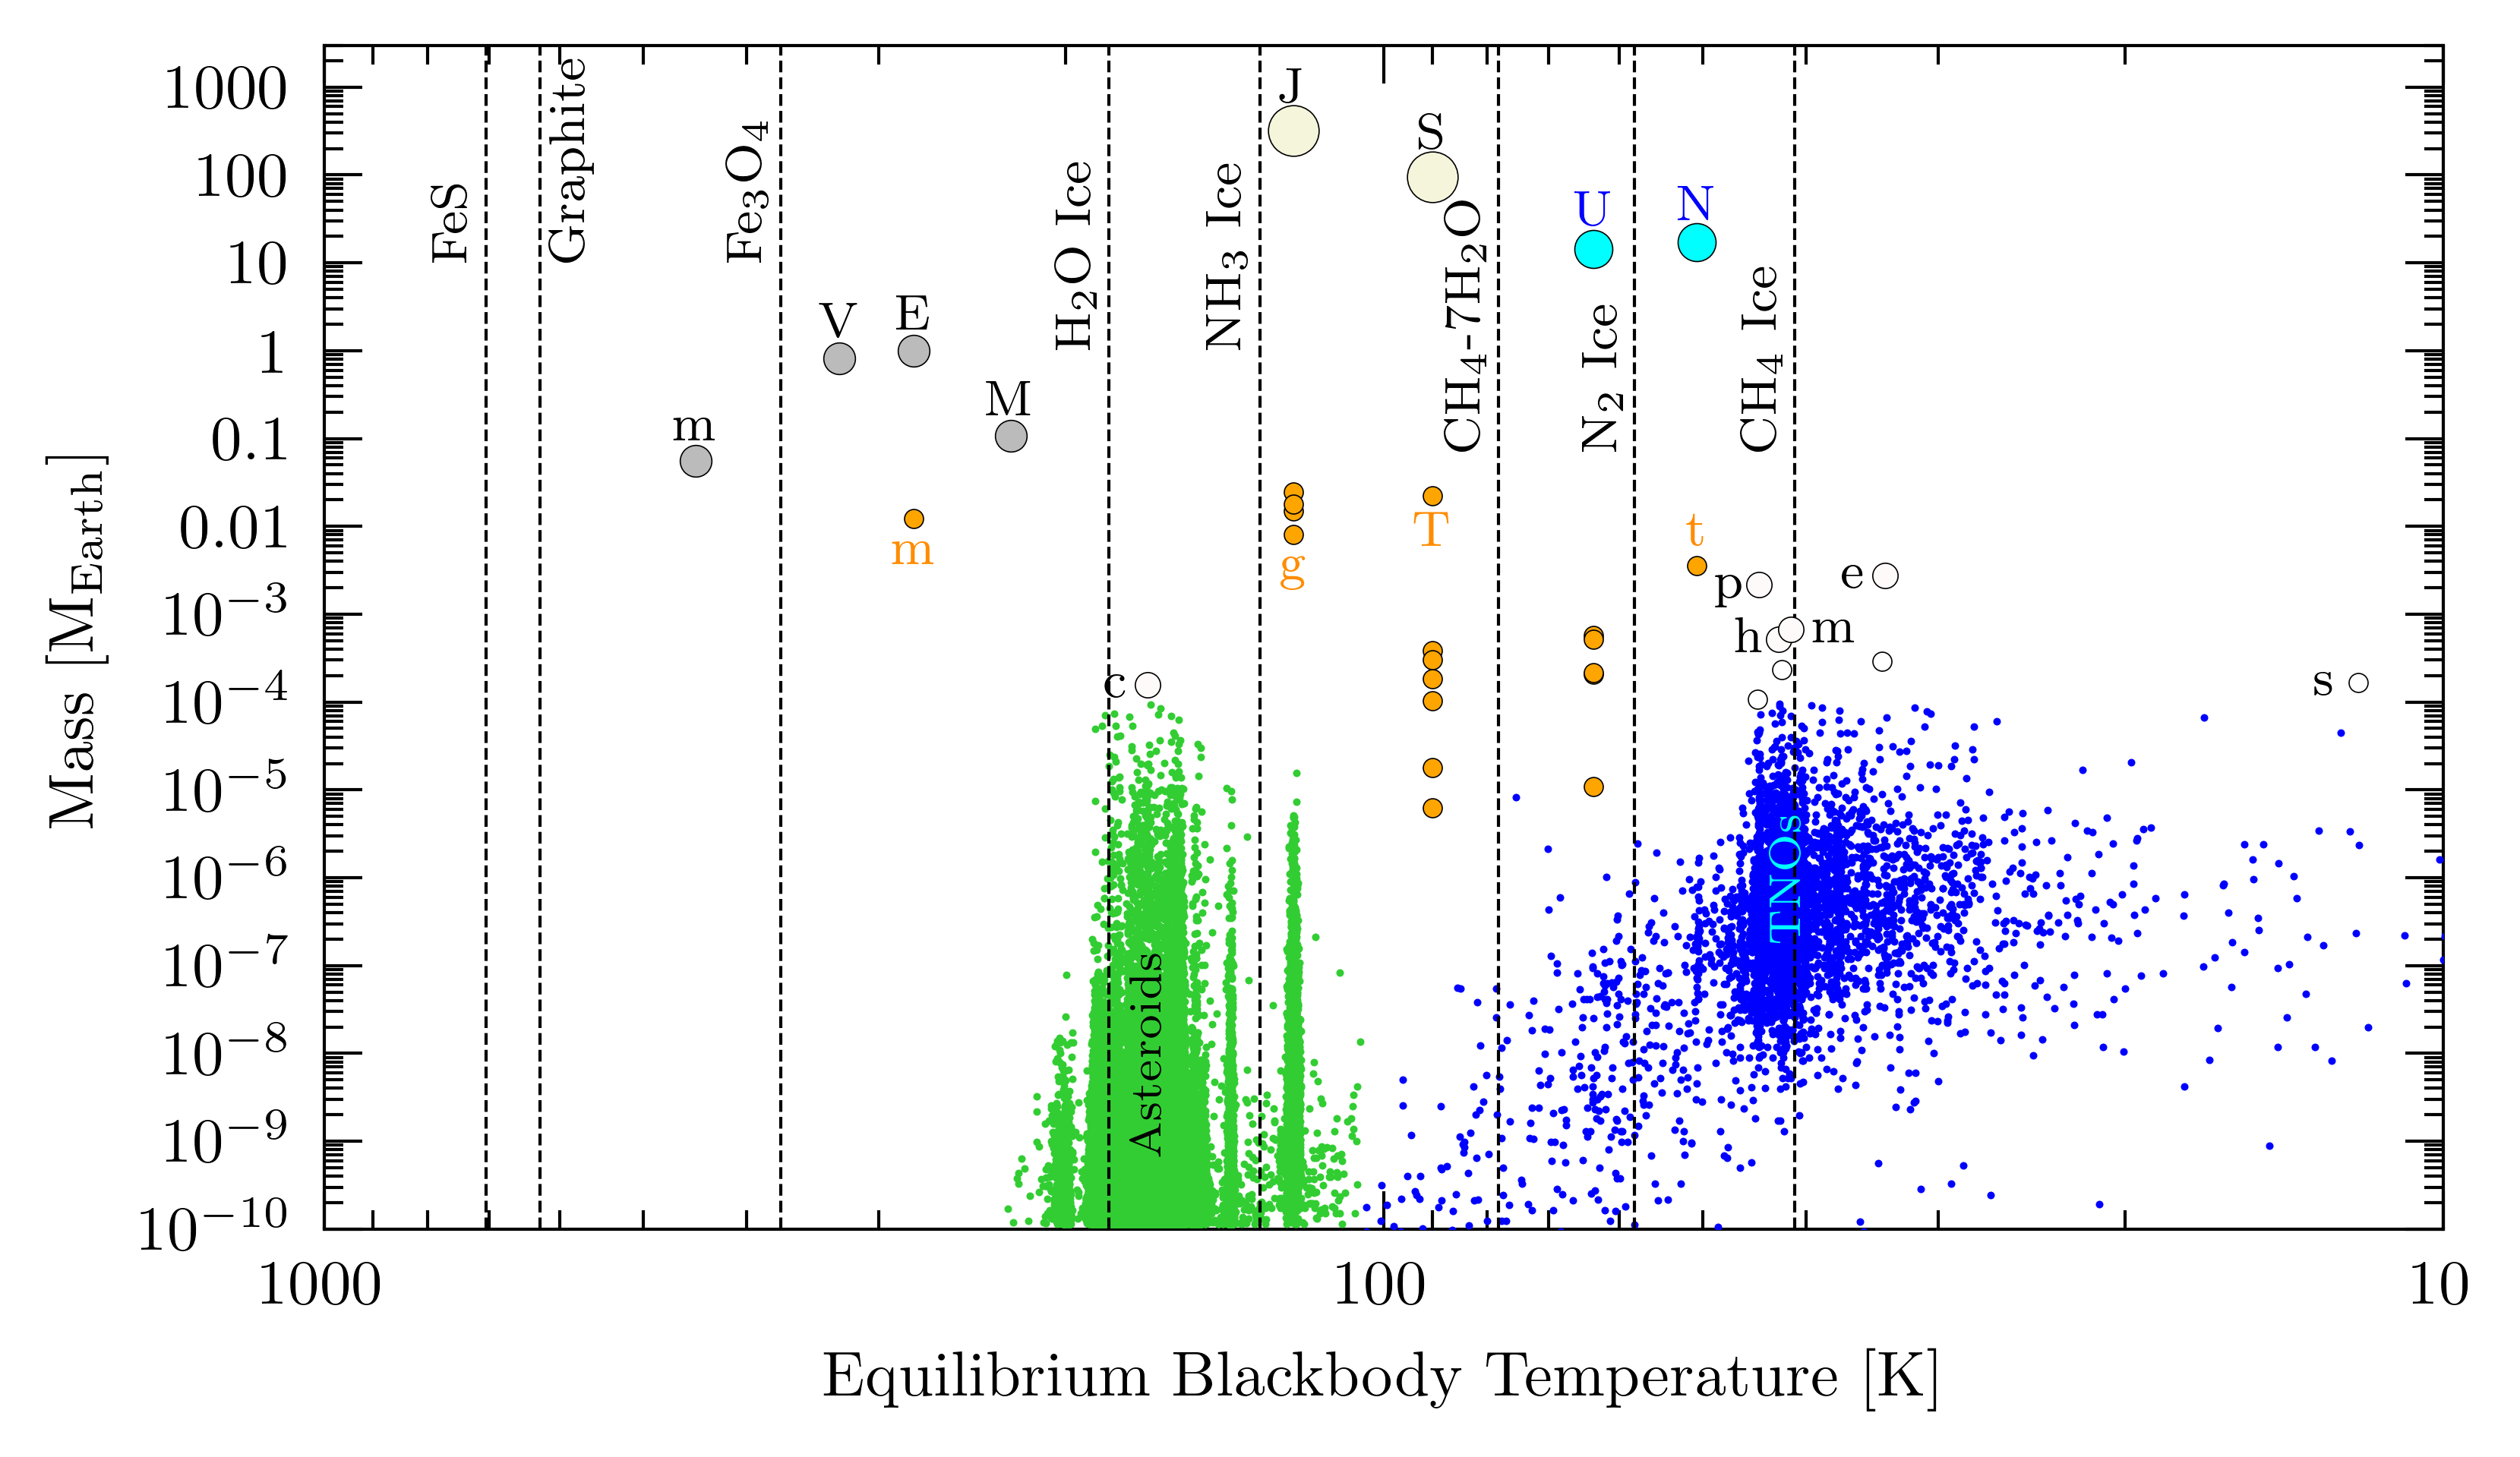

In [7]:
plotFile = f'solSys_Teq_{aspStr}.png'

# axis limits

bbtMin = 1000 # au
bbtMax = 10 # au
mMin = 1.0e-10 # M_earth
mMax = 3000. # M_earth

# do it

fig,ax = plt.subplots(figsize=(wInches,hInches),dpi=dpi)

ax.tick_params('both',length=6,width=lwidth,which='major',direction='in',top=True,right=True)
ax.tick_params('both',length=3,width=lwidth,which='minor',direction='in',top=True,right=True)

ax.set_xlim(bbtMin,bbtMax)
ax.set_xscale('log')
ax.set_xticks([1000,100,10])
ax.set_xticklabels(['1000','100','10'])
ax.set_xlabel(r'Equilibrium Blackbody Temperature [K]',fontsize=axisFontSize)

ax.set_ylim(mMin,mMax)
ax.set_yscale('log')
ax.yaxis.set_major_locator(LogLocator(base=10.0,subs=(1.0,),numticks=100))
ax.yaxis.set_minor_locator(LogLocator(base=10.0,subs=np.arange(2,10)*0.1,numticks=100))
ax.yaxis.set_minor_formatter(NullFormatter())
ax.set_yticks([1.0e-10,1.0e-9,1.0e-8,1.0e-7,1.0e-6,1.0e-5,0.0001,0.001,0.01,0.1,1,10,100,1000])
ax.set_yticklabels([r'10$^{-10}$',r'10$^{-9}$',r'10$^{-8}$',r'10$^{-7}$',r'10$^{-6}$',
                    r'10$^{-5}$',r'10$^{-4}$',r'10$^{-3}$','0.01','0.1','1','10','100','1000'])
ax.set_ylabel(r'Mass [M$_{\rm Earth}$]',fontsize=axisFontSize)

# Major bodies (planets, dwarf planets, giant moons)

for i in range(len(bodyName)):
    t = bodyType[i]
    
    ax.plot(bodyTeq[i],bodyMass[i],'o',mfc=bodyColor[t],mec='black',ms=bodySize[t],mew=0.2,zorder=10)
    if t == 'D':
        labelTxt = bodyName[i].lower()
        if bodyName[i] in ['Pluto','Eris','Ceres']:
            ax.text(1.1*bodyTeq[i],bodyMass[i],labelTxt[0],va='center',ha='left',fontsize=labelFontSize,
                    color='black')
        elif bodyName[i] == 'Makemake':
            ax.text(bodyTeq[i]/1.1,bodyMass[i],'m',va='center',ha='center',fontsize=labelFontSize,
                    color='black')
        elif bodyName[i] == 'Haumea':
            ax.text(bodyTeq[i]*1.1,bodyMass[i],'h',va='center',ha='left',fontsize=labelFontSize,
                    color='black')
            
    elif t == 'GM':
        if bodyName[i]=='Europa':
            ax.text(bodyTeq[i],bodyMass[i]/1.3,'g',va='top',ha='center',fontsize=labelFontSize,color='darkorange')
        elif bodyName[i]=='Titan':
            ax.text(bodyTeq[i],bodyMass[i]/1.5,'T',va='top',ha='center',fontsize=labelFontSize,color='darkorange')
        elif bodyName[i]=='Moon':
            ax.text(bodyTeq[i],bodyMass[i]/1.3,'m',va='top',ha='center',fontsize=labelFontSize,color='darkorange')
        elif bodyName[i]=='Triton':
            ax.text(bodyTeq[i],1.3*bodyMass[i],'t',va='bottom',ha='center',fontsize=labelFontSize,color='darkorange')

    elif t == 'DC':
        if bodyName[i] == 'Sedna':
            ax.text(1.1*bodyTeq[i],bodyMass[i],'s',va='center',ha='left',fontsize=labelFontSize,
                    color='black')

    elif t == 'G':
        labelTxt = bodyName[i]
        ax.text(bodyTeq[i],1.6*bodyMass[i],labelTxt[0],va='bottom',ha='center',fontsize=labelFontSize,
                color='black')    
    elif t == 'I':
        labelTxt = bodyName[i]
        ax.text(bodyTeq[i],1.4*bodyMass[i],labelTxt[0],va='bottom',ha='center',fontsize=labelFontSize,
                color='blue')    
    elif t == 'T':
        labelTxt = bodyName[i][0]
        if bodyName[i]=='Mercury':
            ax.text(bodyTeq[i],1.35*bodyMass[i],'m',va='bottom',ha='center',fontsize=labelFontSize,
                color='black')
        else:
            ax.text(bodyTeq[i],1.35*bodyMass[i],labelTxt,va='bottom',ha='center',fontsize=labelFontSize,
                color='black')
        
# minor planets

ax.plot(astTeq,astMass,'o',mfc='limegreen',mec='limegreen',mew=0.2,ms=1,zorder=8)
tAsts = 278/math.sqrt(2.8)
ax.text(tAsts,1.0e-8,'Asteroids',va='center',ha='center',rotation=90,fontsize=7,zorder=10)

tTNOs = 278/math.sqrt(45)
ax.plot(tnoTeq,tnoMass,'o',mfc='blue',mec='blue',mew=0.2,ms=1,zorder=8)
#ax.text(45,1.0e-10,'TNOs',color='blue',va='center',ha='center',rotation=90,fontsize=labelFontSize,zorder=10)
ax.text(tTNOs,1.0e-6,'TNOs',color='cyan',va='center',ha='center',rotation=90,fontsize=7,zorder=10)

# Equilibrium temperatures for different species

for x in species:
    ax.vlines(Tcond[x],mMin,mMax,ls=['--'],colors=['black'],lw=0.5,zorder=8)
    if x == 'Graphite':
        ax.text(Tcond[x]/1.02,10,Tlabels[x],rotation=90,va='bottom',ha='left',fontsize=labelFontSize)
    else:
        if Tcond[x] > 300:
            ax.text(1.02*Tcond[x],10,Tlabels[x],rotation=90,va='bottom',ha='right',fontsize=labelFontSize)
        elif Tcond[x] < 300 and Tcond[x] > 100:
            ax.text(1.02*Tcond[x],1,Tlabels[x],rotation=90,va='bottom',ha='right',fontsize=labelFontSize)          
        else:
            ax.text(1.02*Tcond[x],0.07,Tlabels[x],rotation=90,va='bottom',ha='right',fontsize=labelFontSize)
        

# make the plot and hardcopy

plt.savefig(plotFile,bbox_inches='tight',facecolor='white')

plt.show()

## Water Ice Line

Plot M vs. equilibrium blackbody temperature at semi-major axis (a), now delineating the Ice Line for 
H<sub>2</sub>O ice.

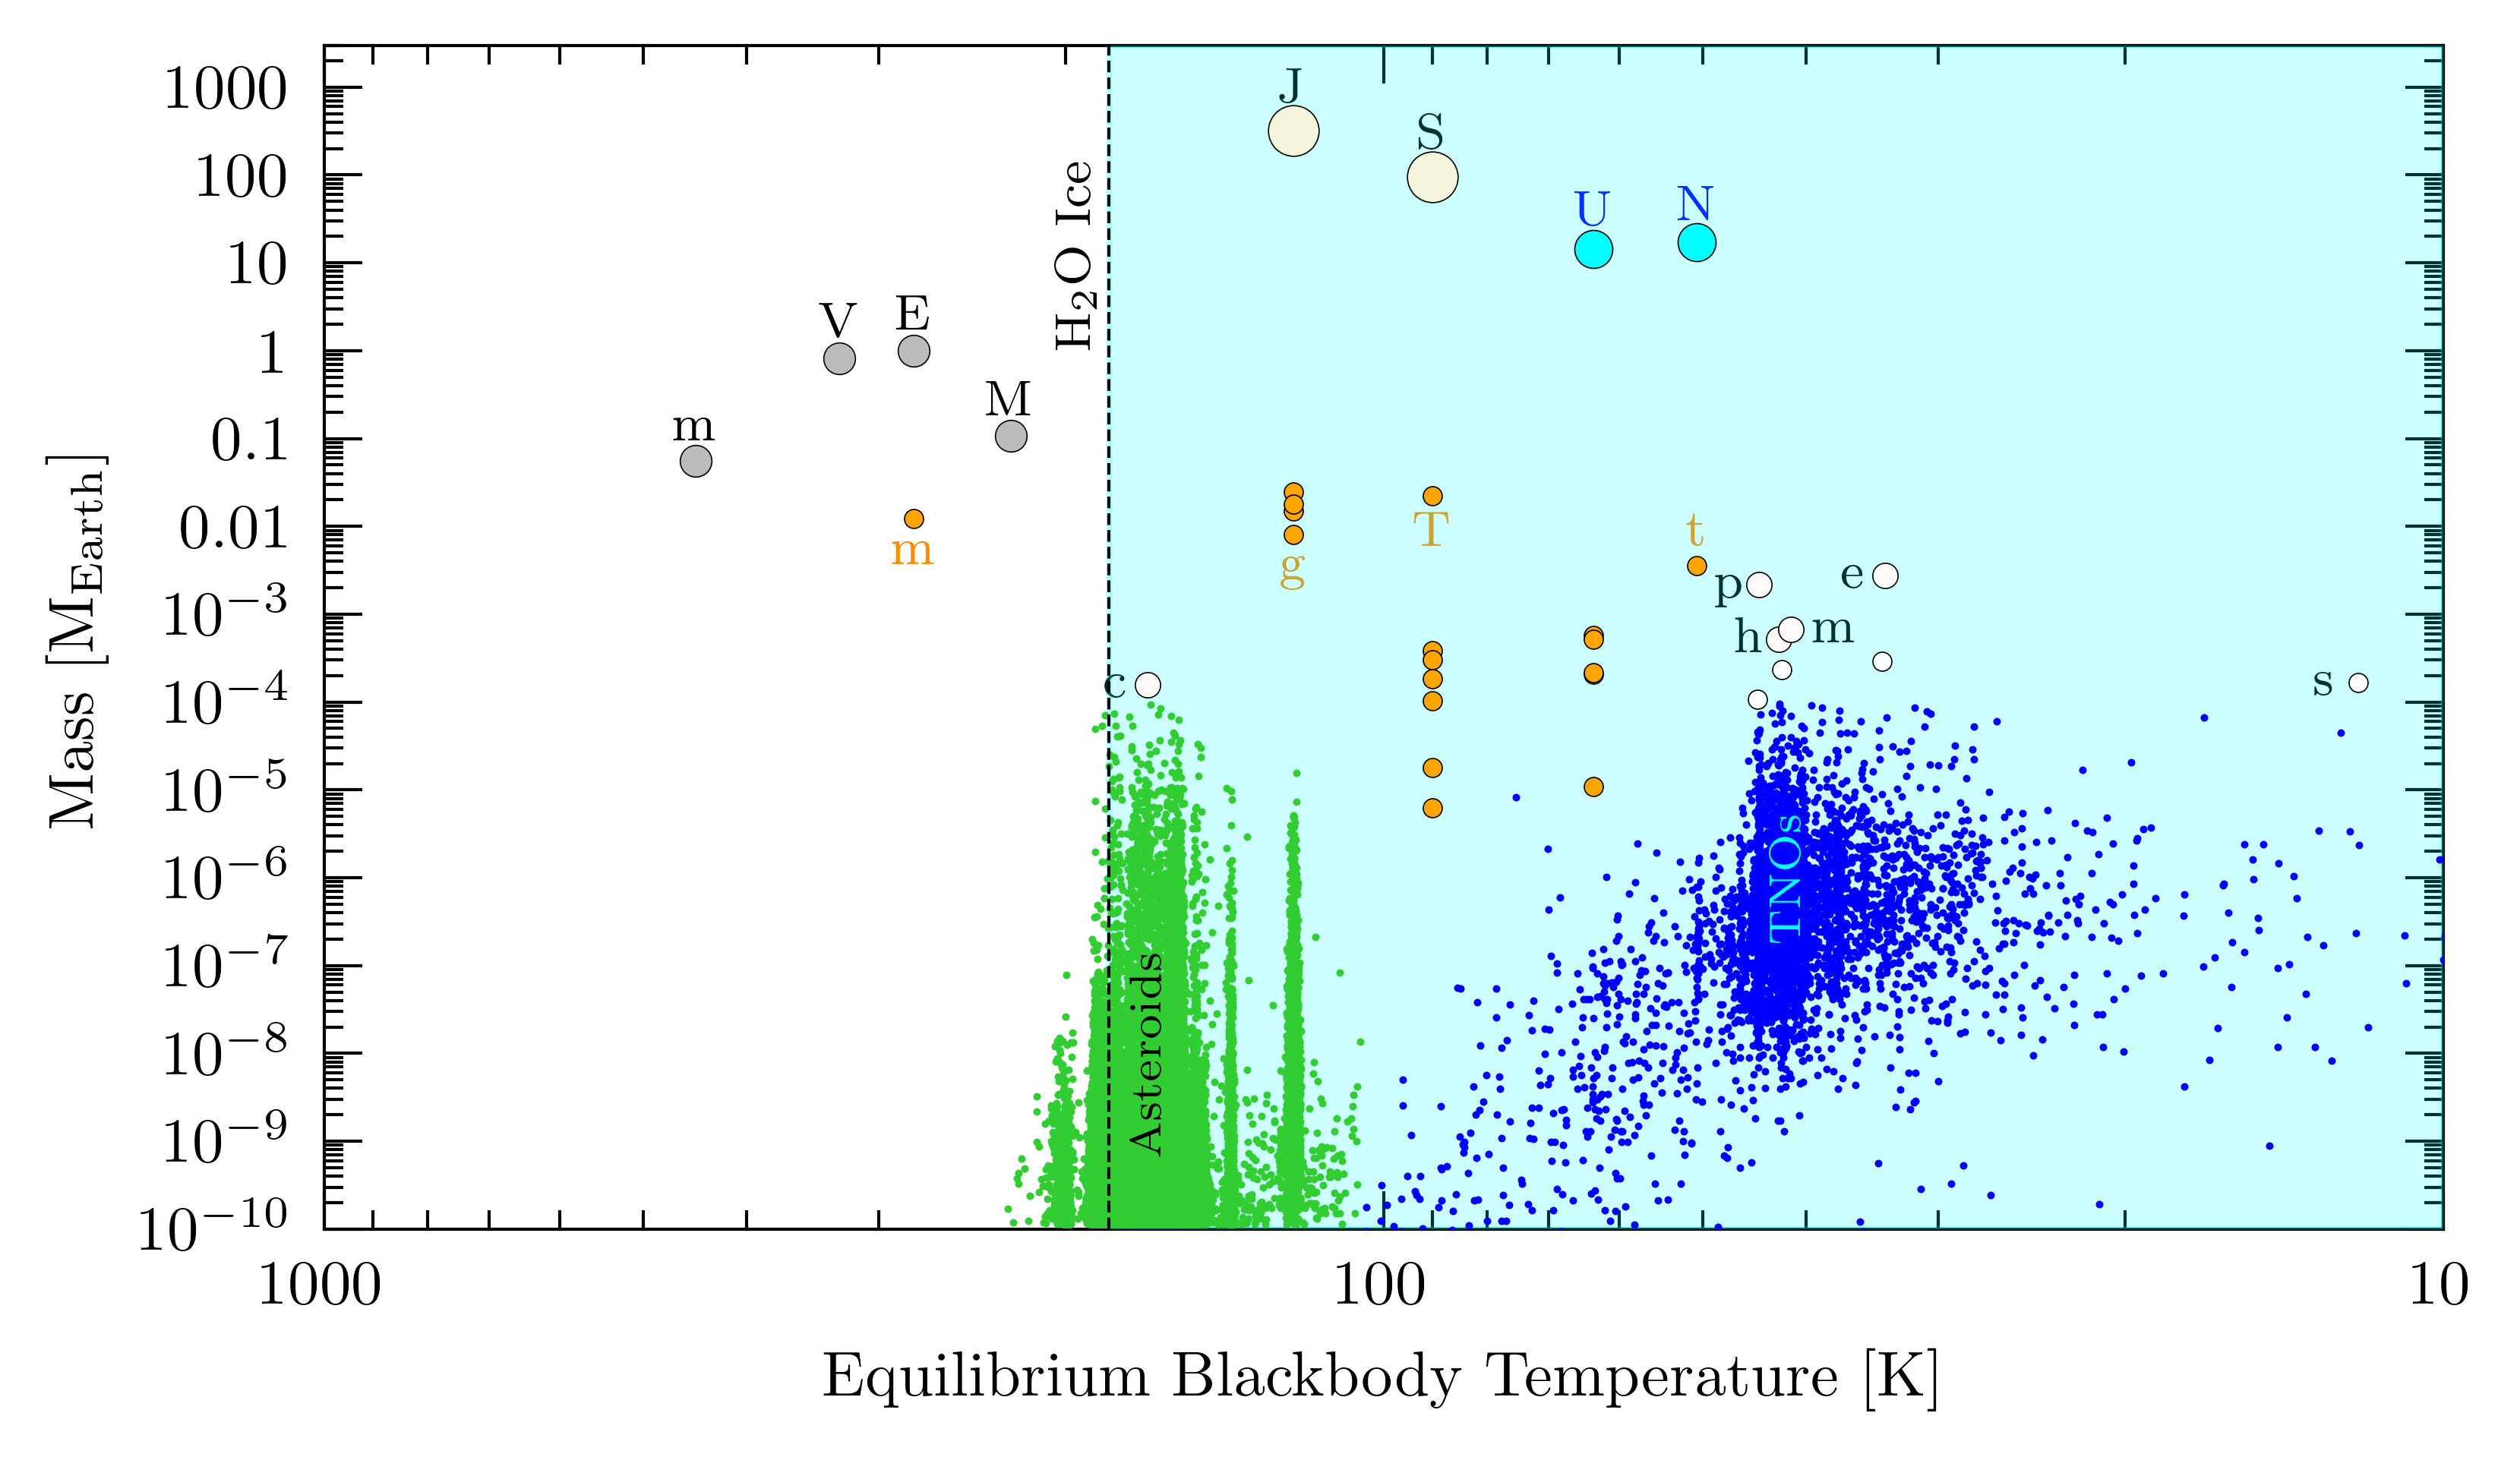

In [8]:
plotFile = f'solSys_iceLine_{aspStr}.png'

# axis limits

bbtMin = 1000 # au
bbtMax = 10 # au
mMin = 1.0e-10 # M_earth
mMax = 3000. # M_earth

# do it

fig,ax = plt.subplots(figsize=(wInches,hInches),dpi=dpi)

ax.tick_params('both',length=6,width=lwidth,which='major',direction='in',top=True,right=True)
ax.tick_params('both',length=3,width=lwidth,which='minor',direction='in',top=True,right=True)

ax.set_xlim(bbtMin,bbtMax)
ax.set_xscale('log')
ax.set_xticks([1000,100,10])
ax.set_xticklabels(['1000','100','10'])
ax.set_xlabel(r'Equilibrium Blackbody Temperature [K]',fontsize=axisFontSize)

ax.set_ylim(mMin,mMax)
ax.set_yscale('log')
ax.yaxis.set_major_locator(LogLocator(base=10.0,subs=(1.0,),numticks=100))
ax.yaxis.set_minor_locator(LogLocator(base=10.0,subs=np.arange(2,10)*0.1,numticks=100))
ax.yaxis.set_minor_formatter(NullFormatter())
ax.set_yticks([1.0e-10,1.0e-9,1.0e-8,1.0e-7,1.0e-6,1.0e-5,0.0001,0.001,0.01,0.1,1,10,100,1000])
ax.set_yticklabels([r'10$^{-10}$',r'10$^{-9}$',r'10$^{-8}$',r'10$^{-7}$',r'10$^{-6}$',
                    r'10$^{-5}$',r'10$^{-4}$',r'10$^{-3}$','0.01','0.1','1','10','100','1000'])
ax.set_ylabel(r'Mass [M$_{\rm Earth}$]',fontsize=axisFontSize)

# Major bodies (planets, dwarf planets, giant moons)

for i in range(len(bodyName)):
    t = bodyType[i]
    
    ax.plot(bodyTeq[i],bodyMass[i],'o',mfc=bodyColor[t],mec='black',ms=bodySize[t],mew=0.2,zorder=10)
    if t == 'D':
        labelTxt = bodyName[i].lower()
        if bodyName[i] in ['Pluto','Eris','Ceres']:
            ax.text(1.1*bodyTeq[i],bodyMass[i],labelTxt[0],va='center',ha='left',fontsize=labelFontSize,
                    color='black')
        elif bodyName[i] == 'Makemake':
            ax.text(bodyTeq[i]/1.1,bodyMass[i],'m',va='center',ha='center',fontsize=labelFontSize,
                    color='black')
        elif bodyName[i] == 'Haumea':
            ax.text(bodyTeq[i]*1.1,bodyMass[i],'h',va='center',ha='left',fontsize=labelFontSize,
                    color='black')
            
    elif t == 'GM':
        if bodyName[i]=='Europa':
            ax.text(bodyTeq[i],bodyMass[i]/1.3,'g',va='top',ha='center',fontsize=labelFontSize,color='darkorange')
        elif bodyName[i]=='Titan':
            ax.text(bodyTeq[i],bodyMass[i]/1.5,'T',va='top',ha='center',fontsize=labelFontSize,color='darkorange')
        elif bodyName[i]=='Moon':
            ax.text(bodyTeq[i],bodyMass[i]/1.3,'m',va='top',ha='center',fontsize=labelFontSize,color='darkorange')
        elif bodyName[i]=='Triton':
            ax.text(bodyTeq[i],1.3*bodyMass[i],'t',va='bottom',ha='center',fontsize=labelFontSize,color='darkorange')

    elif t == 'DC':
        if bodyName[i] == 'Sedna':
            ax.text(1.1*bodyTeq[i],bodyMass[i],'s',va='center',ha='left',fontsize=labelFontSize,
                    color='black')

    elif t == 'G':
        labelTxt = bodyName[i]
        ax.text(bodyTeq[i],1.6*bodyMass[i],labelTxt[0],va='bottom',ha='center',fontsize=labelFontSize,
                color='black')    
    elif t == 'I':
        labelTxt = bodyName[i]
        ax.text(bodyTeq[i],1.4*bodyMass[i],labelTxt[0],va='bottom',ha='center',fontsize=labelFontSize,
                color='blue')    
    elif t == 'T':
        labelTxt = bodyName[i][0]
        if bodyName[i]=='Mercury':
            ax.text(bodyTeq[i],1.35*bodyMass[i],'m',va='bottom',ha='center',fontsize=labelFontSize,
                color='black')
        else:
            ax.text(bodyTeq[i],1.35*bodyMass[i],labelTxt,va='bottom',ha='center',fontsize=labelFontSize,
                color='black')
        
# minor planets

ax.plot(astTeq,astMass,'o',mfc='limegreen',mec='limegreen',mew=0.2,ms=1,zorder=8)
tAsts = 278/math.sqrt(2.8)
ax.text(tAsts,1.0e-8,'Asteroids',va='center',ha='center',rotation=90,fontsize=7,zorder=10)

tTNOs = 278/math.sqrt(45)
ax.plot(tnoTeq,tnoMass,'o',mfc='blue',mec='blue',mew=0.2,ms=1,zorder=8)
#ax.text(45,1.0e-10,'TNOs',color='blue',va='center',ha='center',rotation=90,fontsize=labelFontSize,zorder=10)
ax.text(tTNOs,1.0e-6,'TNOs',color='cyan',va='center',ha='center',rotation=90,fontsize=7,zorder=10)

# water ice line - fill the water ice zone with cyan

x = 'H2O'
ax.vlines(Tcond[x],mMin,mMax,ls=['--'],colors=['black'],lw=0.5,zorder=8)
if Tcond[x] > 300:
    ax.text(1.02*Tcond[x],10,Tlabels[x],rotation=90,va='bottom',ha='right',fontsize=labelFontSize)
elif Tcond[x] < 300 and Tcond[x] > 100:
    ax.text(1.02*Tcond[x],1,Tlabels[x],rotation=90,va='bottom',ha='right',fontsize=labelFontSize)          
else:
    ax.text(1.02*Tcond[x],0.07,Tlabels[x],rotation=90,va='bottom',ha='right',fontsize=labelFontSize)

ax.axvspan(Tcond[x],bbtMax,alpha=0.2, color='cyan',zorder=4)

# make the plot and hardcopy

plt.savefig(plotFile,bbox_inches='tight',facecolor='white')

plt.show()

## N$_2$ Ice Line

Plot M vs. equilibrium blackbody temperature at semi-major axis (a), now delineating the Ice Line for N<sub>2</sub>
ice.

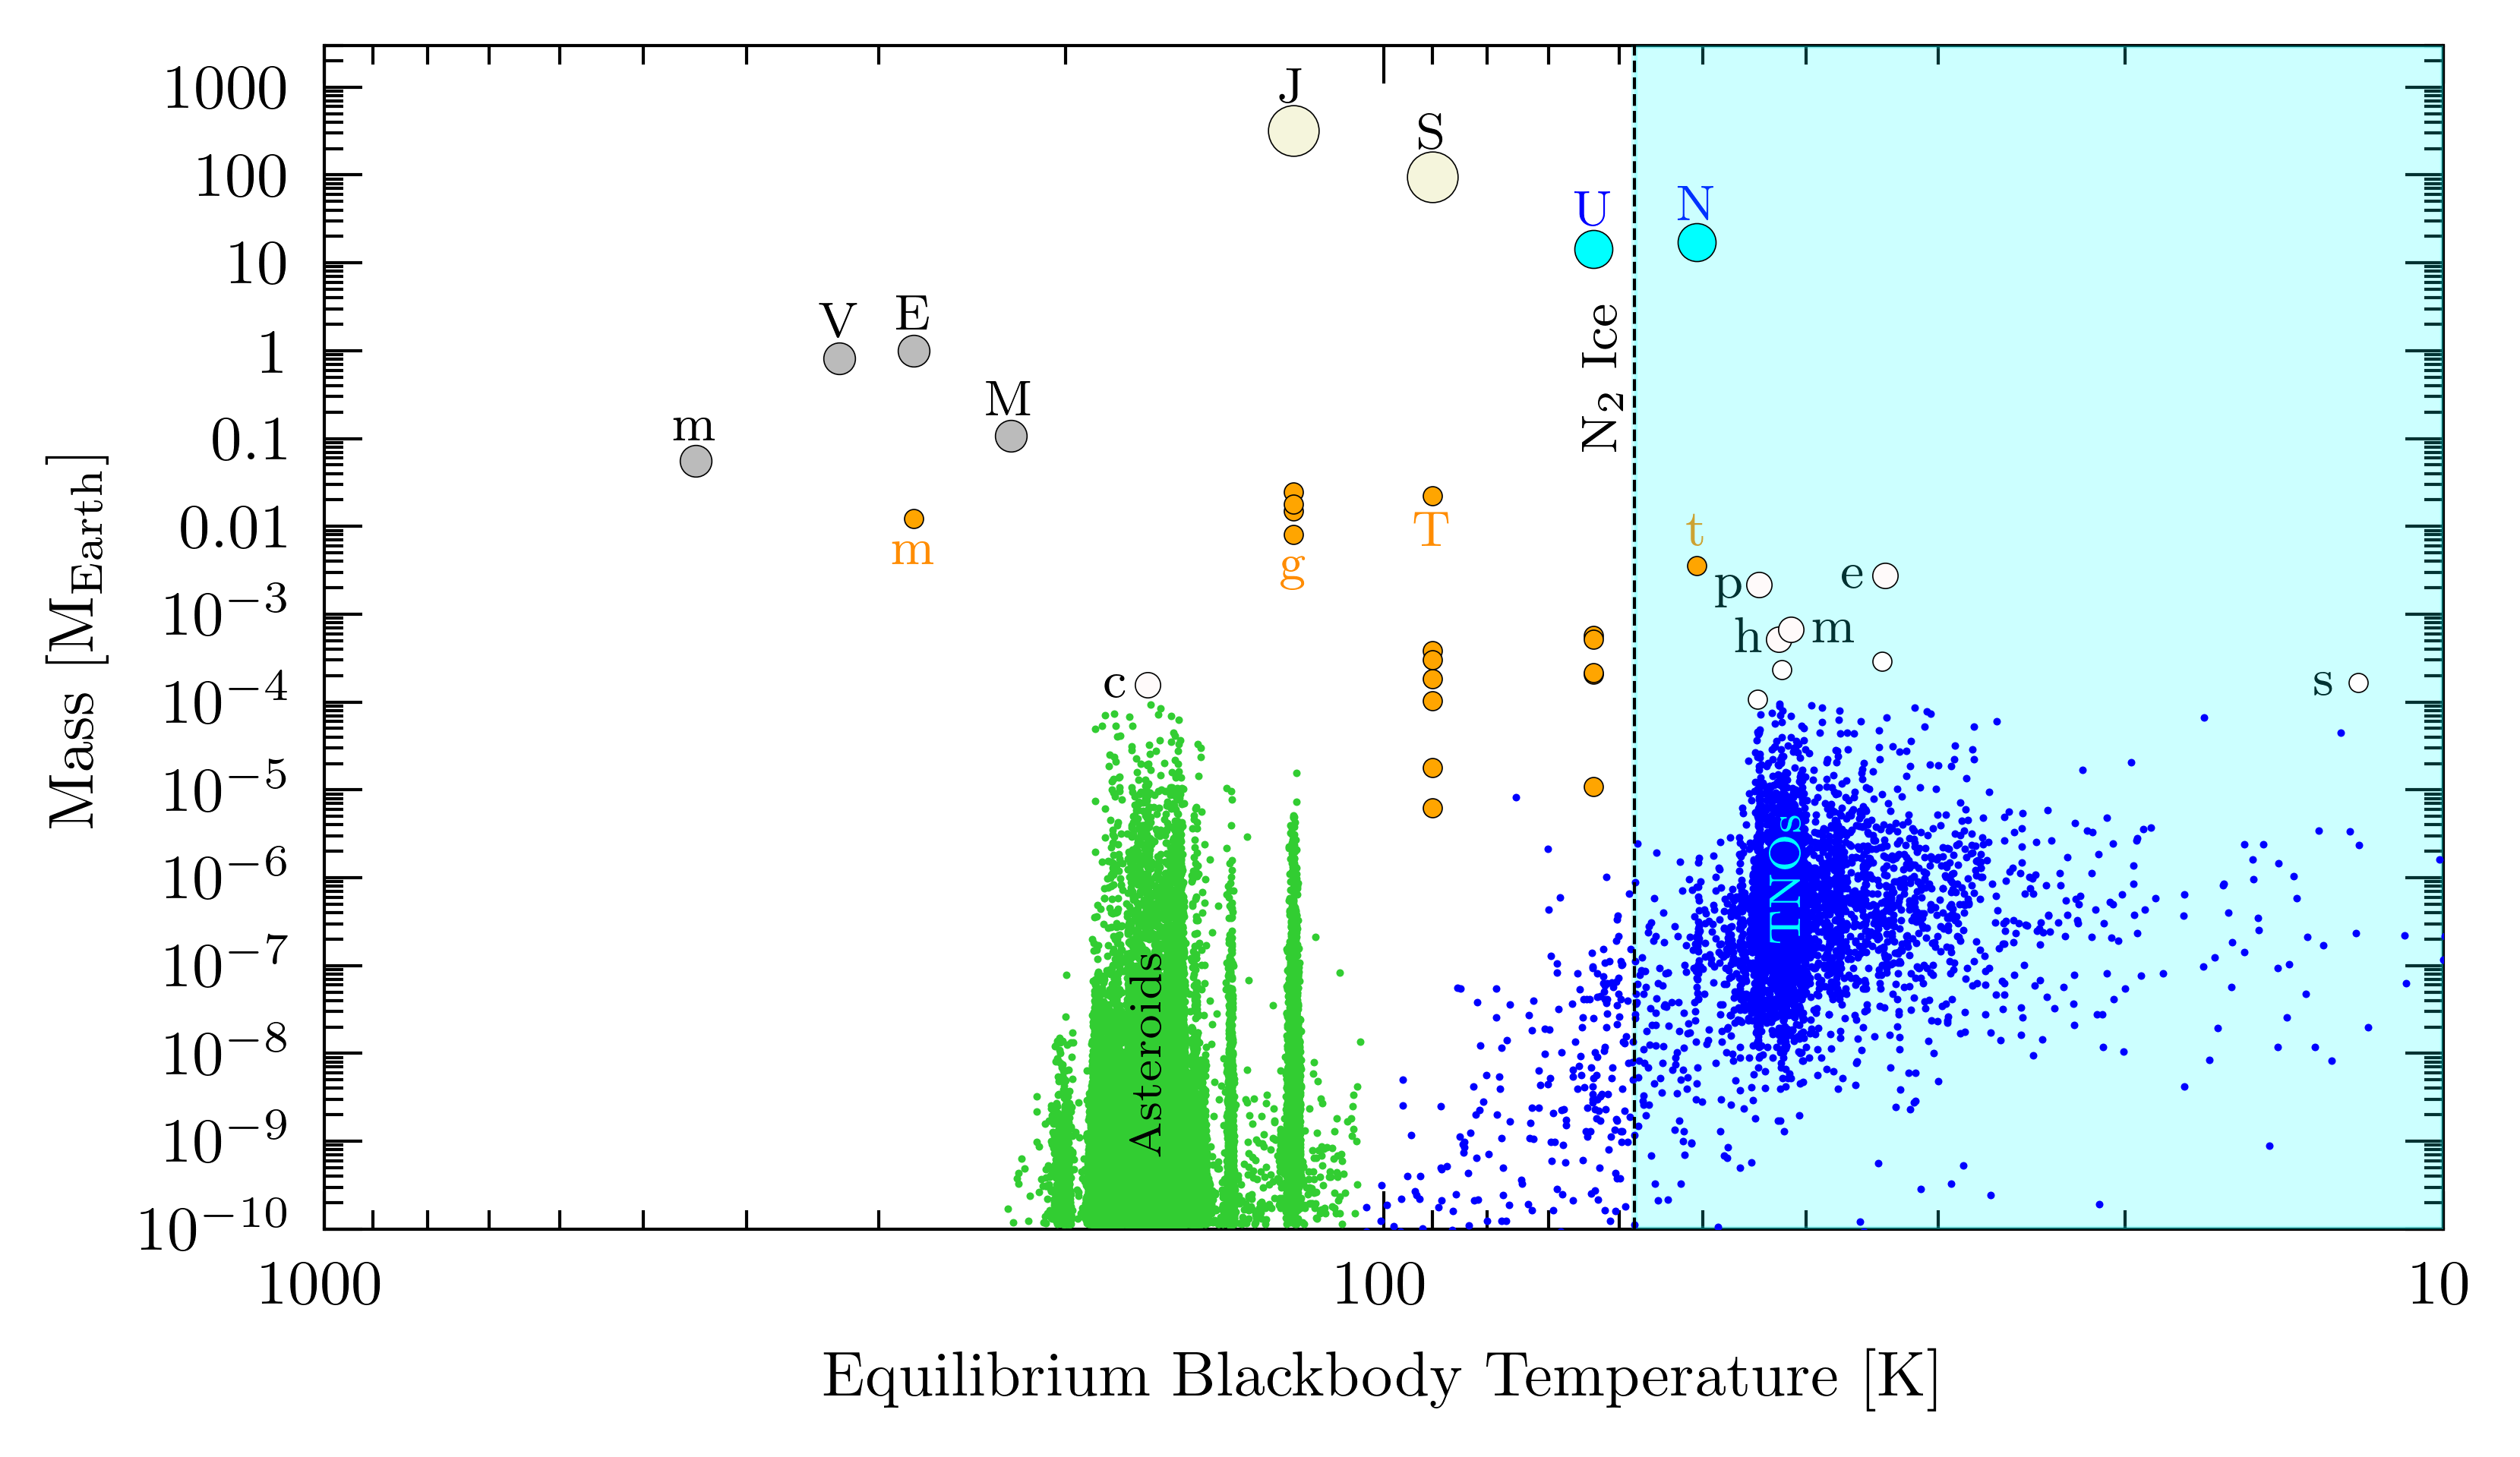

In [9]:
plotFile = f'solSys_n2Line_{aspStr}.png'

# axis limits

bbtMin = 1000 # au
bbtMax = 10 # au
mMin = 1.0e-10 # M_earth
mMax = 3000. # M_earth

# do it

fig,ax = plt.subplots(figsize=(wInches,hInches),dpi=dpi)

ax.tick_params('both',length=6,width=lwidth,which='major',direction='in',top=True,right=True)
ax.tick_params('both',length=3,width=lwidth,which='minor',direction='in',top=True,right=True)

ax.set_xlim(bbtMin,bbtMax)
ax.set_xscale('log')
ax.set_xticks([1000,100,10])
ax.set_xticklabels(['1000','100','10'])
ax.set_xlabel(r'Equilibrium Blackbody Temperature [K]',fontsize=axisFontSize)

ax.set_ylim(mMin,mMax)
ax.set_yscale('log')
ax.yaxis.set_major_locator(LogLocator(base=10.0,subs=(1.0,),numticks=100))
ax.yaxis.set_minor_locator(LogLocator(base=10.0,subs=np.arange(2,10)*0.1,numticks=100))
ax.yaxis.set_minor_formatter(NullFormatter())
ax.set_yticks([1.0e-10,1.0e-9,1.0e-8,1.0e-7,1.0e-6,1.0e-5,0.0001,0.001,0.01,0.1,1,10,100,1000])
ax.set_yticklabels([r'10$^{-10}$',r'10$^{-9}$',r'10$^{-8}$',r'10$^{-7}$',r'10$^{-6}$',
                    r'10$^{-5}$',r'10$^{-4}$',r'10$^{-3}$','0.01','0.1','1','10','100','1000'])
ax.set_ylabel(r'Mass [M$_{\rm Earth}$]',fontsize=axisFontSize)

# Major bodies (planets, dwarf planets, giant moons)

for i in range(len(bodyName)):
    t = bodyType[i]
    
    ax.plot(bodyTeq[i],bodyMass[i],'o',mfc=bodyColor[t],mec='black',ms=bodySize[t],mew=0.2,zorder=10)
    if t == 'D':
        labelTxt = bodyName[i].lower()
        if bodyName[i] in ['Pluto','Eris','Ceres']:
            ax.text(1.1*bodyTeq[i],bodyMass[i],labelTxt[0],va='center',ha='left',fontsize=labelFontSize,
                    color='black')
        elif bodyName[i] == 'Makemake':
            ax.text(bodyTeq[i]/1.1,bodyMass[i],'m',va='center',ha='center',fontsize=labelFontSize,
                    color='black')
        elif bodyName[i] == 'Haumea':
            ax.text(bodyTeq[i]*1.1,bodyMass[i],'h',va='center',ha='left',fontsize=labelFontSize,
                    color='black')
            
    elif t == 'GM':
        if bodyName[i]=='Europa':
            ax.text(bodyTeq[i],bodyMass[i]/1.3,'g',va='top',ha='center',fontsize=labelFontSize,color='darkorange')
        elif bodyName[i]=='Titan':
            ax.text(bodyTeq[i],bodyMass[i]/1.5,'T',va='top',ha='center',fontsize=labelFontSize,color='darkorange')
        elif bodyName[i]=='Moon':
            ax.text(bodyTeq[i],bodyMass[i]/1.3,'m',va='top',ha='center',fontsize=labelFontSize,color='darkorange')
        elif bodyName[i]=='Triton':
            ax.text(bodyTeq[i],1.3*bodyMass[i],'t',va='bottom',ha='center',fontsize=labelFontSize,color='darkorange')

    elif t == 'DC':
        if bodyName[i] == 'Sedna':
            ax.text(1.1*bodyTeq[i],bodyMass[i],'s',va='center',ha='left',fontsize=labelFontSize,
                    color='black')

    elif t == 'G':
        labelTxt = bodyName[i]
        ax.text(bodyTeq[i],1.6*bodyMass[i],labelTxt[0],va='bottom',ha='center',fontsize=labelFontSize,
                color='black')    
    elif t == 'I':
        labelTxt = bodyName[i]
        ax.text(bodyTeq[i],1.4*bodyMass[i],labelTxt[0],va='bottom',ha='center',fontsize=labelFontSize,
                color='blue')    
    elif t == 'T':
        labelTxt = bodyName[i][0]
        if bodyName[i]=='Mercury':
            ax.text(bodyTeq[i],1.35*bodyMass[i],'m',va='bottom',ha='center',fontsize=labelFontSize,
                color='black')
        else:
            ax.text(bodyTeq[i],1.35*bodyMass[i],labelTxt,va='bottom',ha='center',fontsize=labelFontSize,
                color='black')
        
# minor planets

ax.plot(astTeq,astMass,'o',mfc='limegreen',mec='limegreen',mew=0.2,ms=1,zorder=8)
tAsts = 278/math.sqrt(2.8)
ax.text(tAsts,1.0e-8,'Asteroids',va='center',ha='center',rotation=90,fontsize=7,zorder=10)

tTNOs = 278/math.sqrt(45)
ax.plot(tnoTeq,tnoMass,'o',mfc='blue',mec='blue',mew=0.2,ms=1,zorder=8)
#ax.text(45,1.0e-10,'TNOs',color='blue',va='center',ha='center',rotation=90,fontsize=labelFontSize,zorder=10)
ax.text(tTNOs,1.0e-6,'TNOs',color='cyan',va='center',ha='center',rotation=90,fontsize=7,zorder=10)

# N2 ice line - fill the N2 ice zone with cyan

x = 'N2'
ax.vlines(Tcond[x],mMin,mMax,ls=['--'],colors=['black'],lw=0.5,zorder=8)
if Tcond[x] > 300:
    ax.text(1.02*Tcond[x],10,Tlabels[x],rotation=90,va='bottom',ha='right',fontsize=labelFontSize)
elif Tcond[x] < 300 and Tcond[x] > 100:
    ax.text(1.02*Tcond[x],1,Tlabels[x],rotation=90,va='bottom',ha='right',fontsize=labelFontSize)          
else:
    ax.text(1.02*Tcond[x],0.07,Tlabels[x],rotation=90,va='bottom',ha='right',fontsize=labelFontSize)

ax.axvspan(Tcond[x],bbtMax,alpha=0.2, color='cyan',zorder=4)

# make the plot and hardcopy

plt.savefig(plotFile,bbox_inches='tight',facecolor='white')

plt.show()